In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing necessary libraries and packages
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import glob
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, ReLU, Flatten, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
print(tf.__version__)

2.15.0


## 1. Loading Data

In [ ]:
orig_dir = "/content/drive/MyDrive/Datasets/Cocoa Beans"
srcdir = "/content/drive/MyDrive/Datasets/Cocoa Beans Dataset"

In [ ]:
def count_images(directory):
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.gif', '*.bmp']
    total_images = 0
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.relpath(root, directory)
        num_images = 0
        for extension in image_extensions:
            image_files = glob.glob(os.path.join(root, extension))
            num_images += len(image_files)
        if num_images > 0:
            print(f"Folder: {folder_name}, Number of images: {num_images}")
            total_images += num_images
    print(f"Total number of images: {total_images}")

In [ ]:
count_images(orig_dir)

Folder: Whole_Beans_Cocoa, Number of images: 104
Folder: Bean_Fraction_Cocoa, Number of images: 100
Folder: Moldy_Cocoa, Number of images: 105
Folder: Broken_Beans_Cocoa, Number of images: 100
Folder: Unfermented_Cocoa, Number of images: 100
Folder: Fermented_Cocoa, Number of images: 105
Total number of images: 614


In [ ]:
train_dir = '/content/drive/MyDrive/Datasets/Augmented/Cocoa Beans[train]'
validation_dir = '/content/drive/MyDrive/Datasets/Augmented/Cocoa Beans[val]'
test_dir = os.path.join(srcdir, 'test')

#### a. Generating training, validation and test images

In [ ]:
# Hyperparameters
batch_size = 32
image_size = (114, 114)

In [ ]:
# Augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255
    )

In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow images from directories using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 2100 images belonging to 6 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 600 images belonging to 6 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 60 images belonging to 6 classes.


#### b. Analyzing the images

In [ ]:
# Number of samples and classes
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
num_classes = len(classes)
print("Number of classes: ", num_classes)
print('Classes:', classes)


Number of classes:  6
Classes: ['Bean_Fraction_Cocoa', 'Broken_Beans_Cocoa', 'Fermented_Cocoa', 'Moldy_Cocoa', 'Unfermented_Cocoa', 'Whole_Beans_Cocoa']


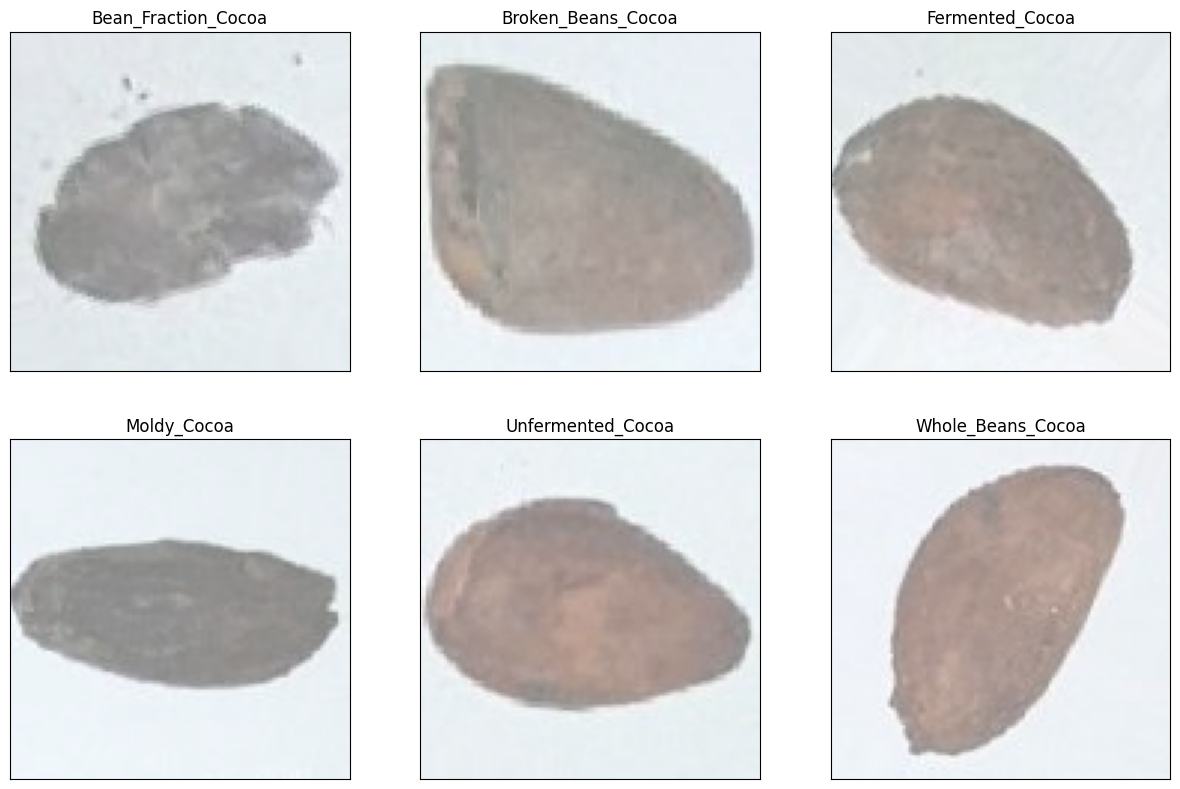

In [ ]:
# Visualize one example from augmented training set
plt.figure(figsize=(15, 15))
for i, class_name in enumerate(classes):
    ax = plt.subplot(3, 3, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Find an image from the current class
    for x_batch, y_batch in train_generator:
        index = list(y_batch[:, i]).index(1)
        image = (x_batch[index] + 1) * 127.5
        image = image.astype('uint8')
        plt.imshow(image)
        plt.title(class_name)
        break
plt.show()

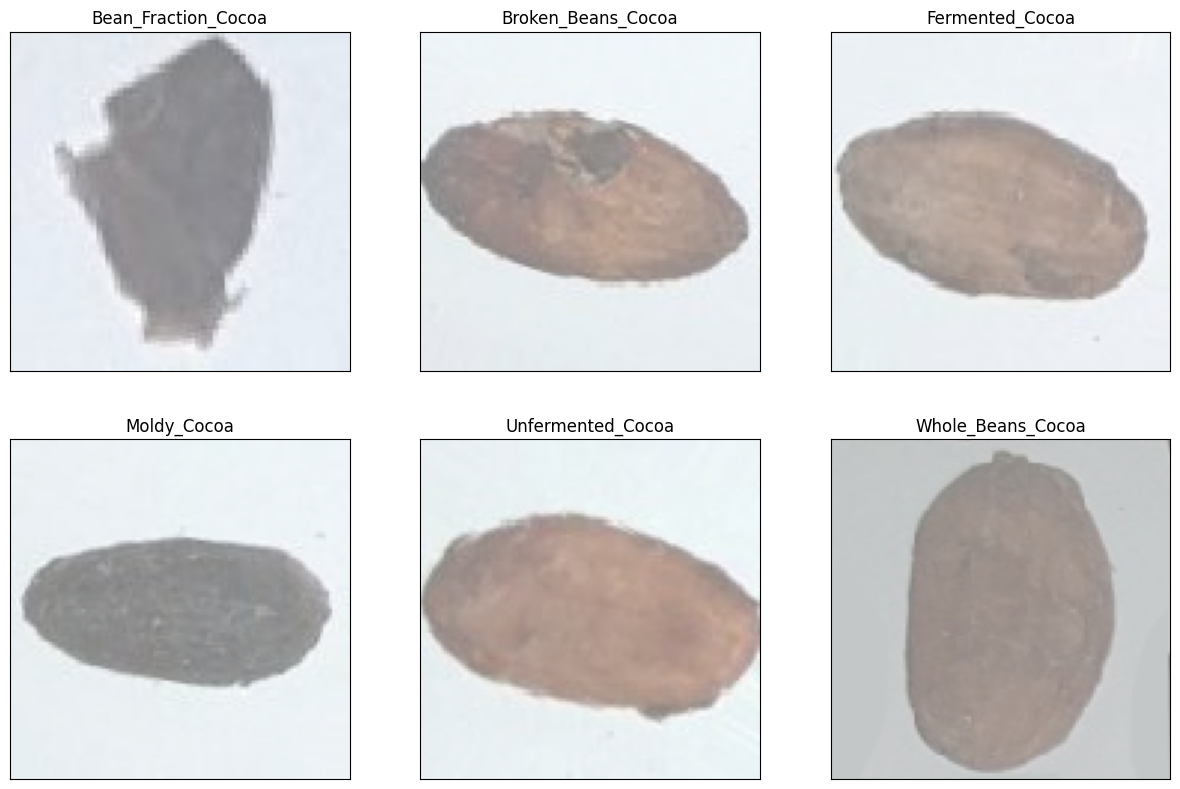

In [ ]:
# Visualize one example from original set
plt.figure(figsize=(15, 15))
for i, class_name in enumerate(classes):
    ax = plt.subplot(3, 3, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Find an image from the current class
    for x_batch, y_batch in validation_generator:
        index = list(y_batch[:, i]).index(1)
        image = (x_batch[index] + 1) * 127.5
        image = image.astype('uint8')
        plt.imshow(image)
        plt.title(class_name)
        break
plt.show()

# Data Modelling

In [ ]:
#@title a. Custom CNN Architecture
def create_cnn_model(image_size, num_classes):
    cnn_model = Sequential([
        # First convolutional layer
        Conv2D(32, (2, 2), activation='relu', input_shape=image_size+(3,), name='Conv_1'),
        MaxPooling2D((2, 2), name='MaxPool_1'),

        # Second convolutional layer
        Conv2D(64, (2, 2), activation='relu', name='Conv_2'),
        MaxPooling2D((2, 2), name='MaxPool_2'),

        # Third convolutional layer
        Conv2D(64, (3, 3), activation='relu', name='Conv_3'),
        MaxPooling2D((2, 2), name='MaxPool_3'),

        # Fourth convolutional layer
        Conv2D(64, (3, 3), activation='relu', name='Conv_4'),
        MaxPooling2D((2, 2), name='MaxPool_4'),

        # Fifth convolutional layer
        Conv2D(64, (2, 2), activation='relu', name='Conv_5'),
        MaxPooling2D((2, 2), name='MaxPool_5'),

        # Flatten the tensor output from the convolutional layers
        Flatten(),

        # First dense layer
        Dense(128, activation='relu', name='Dense_1'),
        Dropout(0.5, name='Dropout_1'),

        # Second dense layer
        Dense(64, activation='relu', name='Dense_2'),
        Dropout(0.5, name='Dropout_2'),

        # Output layer
        Dense(num_classes, activation='softmax', name='Output')
    ])
    # metrics
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ]

    # Compiling the model
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
    return cnn_model

In [ ]:
#@title b. InceptionV3 Model
def create_inceptionv3_model(image_size, num_classes):
    inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=image_size+(3,))
    x = GlobalAveragePooling2D()(inceptionv3.output)
    x = Dense(128, activation='relu', name='Dense_1')(x)
    x = Dropout(0.5, name='Dropout_1')(x)
    x = Dense(64, activation='relu', name='Dense_2')(x)
    x = Dropout(0.5, name='Dropout_2')(x)
    output = Dense(num_classes, activation='softmax', name='Output')(x)

    model = Model(inputs=inceptionv3.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[
        'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    return model

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
#@title c. MobileNet Model
def create_mobilenet_model(image_size, num_classes):
    mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=image_size+(3,))
    x = GlobalAveragePooling2D()(mobilenet.output)
    x = Dense(128, activation='relu', name='Dense_1')(x)
    x = Dropout(0.5, name='Dropout_1')(x)
    x = Dense(64, activation='relu', name='Dense_2')(x)
    x = Dropout(0.5, name='Dropout_2')(x)
    output = Dense(num_classes, activation='softmax', name='Output')(x)

    model = Model(inputs=mobilenet.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[
        'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    return model

In [ ]:
#@title Create Models
cnn_model = create_cnn_model(image_size, num_classes)
inceptionv3_model = create_inceptionv3_model(image_size, num_classes)
mobilenet_model = create_mobilenet_model(image_size, num_classes)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# @title CNN Model Summary
print("Custom CNN Model:")
cnn_model.summary()

Custom CNN Model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 113, 113, 32)      416       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 56, 56, 32)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 55, 55, 64)        8256      
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 27, 27, 64)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 25, 25, 64)        36928     
                                                                 
 MaxPool_3 (MaxPooling2D)    (None, 12, 12, 64)        0         
                                                                 
 Conv_4 (Conv2D)             (None, 10

In [ ]:
#@title InceptionV3 Model Summary
print("\nInceptionV3 Model:")
inceptionv3_model.summary()


InceptionV3 Model:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 114, 114, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 56, 56, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 56, 56, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 56, 56, 32)           0         ['ba

In [ ]:
#@title MobileNet Model Summary
print("\nMobileNet Model:")
mobilenet_model.summary()


MobileNet Model:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 114, 114, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 57, 57, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 57, 57, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 57, 57, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 57, 57, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 57, 5

In [ ]:
# Training and Evaluation
epochs = 50
checkpoint_dir = "/content/drive/MyDrive/Checkpoints/Cocoa_CNN/"

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [ ]:
def train_and_evaluate(model, model_name):
    # Define model checkpoint to save the best model during training
    model_checkpoint = ModelCheckpoint(f"{checkpoint_dir}{model_name}_model_checkpoint.h5", monitor='val_loss', save_best_only=True)

    # Train the model with callbacks
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(
        test_generator,
        steps=test_generator.samples // batch_size
    )

    print(f"\n{model_name} Model:")
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test AUC: {test_auc}")

    # Generate predictions on the test set
    test_steps = test_generator.samples // batch_size
    predictions = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(predictions, axis=1)

    # Get true labels from the test set generator
    y_true = test_generator.classes[:len(predictions)]

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"\n{model_name} Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

Epoch 1/50
65/65 [==============================] - ETA: 0s - loss: 1.7811 - accuracy: 0.1842 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5428

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 450s 7s/step - loss: 1.7811 - accuracy: 0.1842 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5428 - val_loss: 1.6680 - val_accuracy: 0.4306 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7478
Epoch 2/50
65/65 [==============================] - 9s 133ms/step - loss: 1.4800 - accuracy: 0.3868 - precision: 0.6783 - recall: 0.1223 - auc: 0.7563 - val_loss: 1.1962 - val_accuracy: 0.5139 - val_precision: 0.8430 - val_recall: 0.1771 - val_auc: 0.8630
Epoch 3/50
65/65 [==============================] - 9s 138ms/step - loss: 1.1671 - accuracy: 0.4923 - precision: 0.6659 - recall: 0.2824 - auc: 0.8599 - val_loss: 0.9608 - val_accuracy: 0.5469 - val_precision: 0.6938 - val_recall: 0.4288 - val_auc: 0.9044
Epoch 4/50
65/65 [==============================] - 9s 136ms/step - loss: 1.0415 - accuracy: 0.5484 - precision: 0.7049 - recall: 0.3685 - auc: 0.8868 - val_loss: 0.9579 - val_accuracy: 0.5816 - val_precision: 0.6958 - val_recal

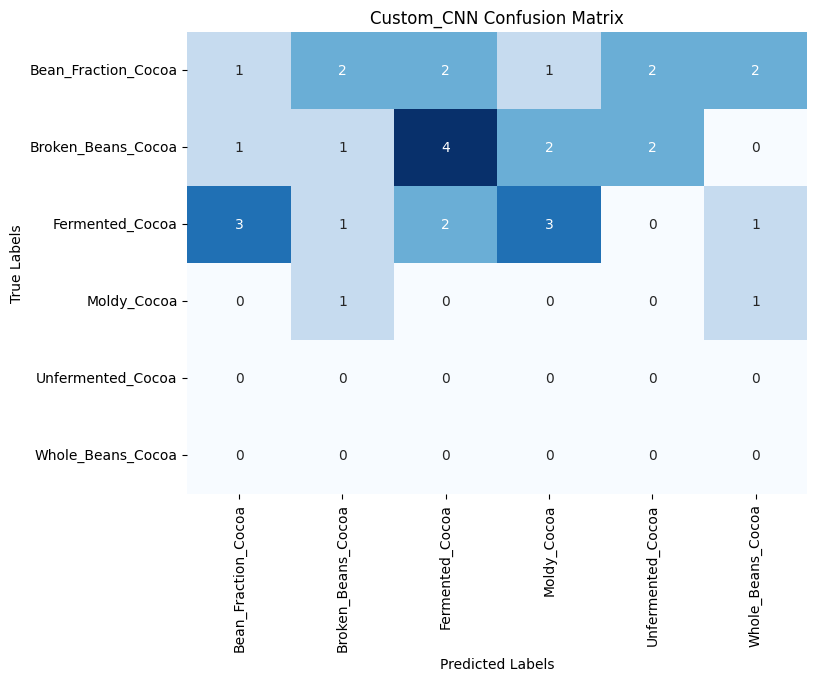

In [ ]:
#@title CNN model training and evaluation
train_and_evaluate(cnn_model, "Custom_CNN")

Epoch 1/50
65/65 [==============================] - ETA: 0s - loss: 1.5780 - accuracy: 0.4057 - precision_2: 0.6628 - recall_2: 0.1644 - auc_2: 0.7615

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 43s 402ms/step - loss: 1.5780 - accuracy: 0.4057 - precision_2: 0.6628 - recall_2: 0.1644 - auc_2: 0.7615 - val_loss: 10.8414 - val_accuracy: 0.4253 - val_precision_2: 0.6894 - val_recall_2: 0.2812 - val_auc_2: 0.7349
Epoch 2/50
65/65 [==============================] - 23s 354ms/step - loss: 1.0862 - accuracy: 0.6054 - precision_2: 0.7717 - recall_2: 0.3989 - auc_2: 0.8866 - val_loss: 809.2006 - val_accuracy: 0.2865 - val_precision_2: 0.2847 - val_recall_2: 0.2812 - val_auc_2: 0.5689
Epoch 3/50
65/65 [==============================] - 27s 421ms/step - loss: 0.9539 - accuracy: 0.6634 - precision_2: 0.7918 - recall_2: 0.5019 - auc_2: 0.9146 - val_loss: 1.4222 - val_accuracy: 0.5295 - val_precision_2: 0.6742 - val_recall_2: 0.4132 - val_auc_2: 0.8473
Epoch 4/50
65/65 [==============================] - 25s 374ms/step - loss: 0.8859 - accuracy: 0.6992 - precision_2: 0.8031 - recall_2: 0.5542 - auc_2: 0.9249 - val_loss: 1.7021 - val_accuracy: 0.6163 -

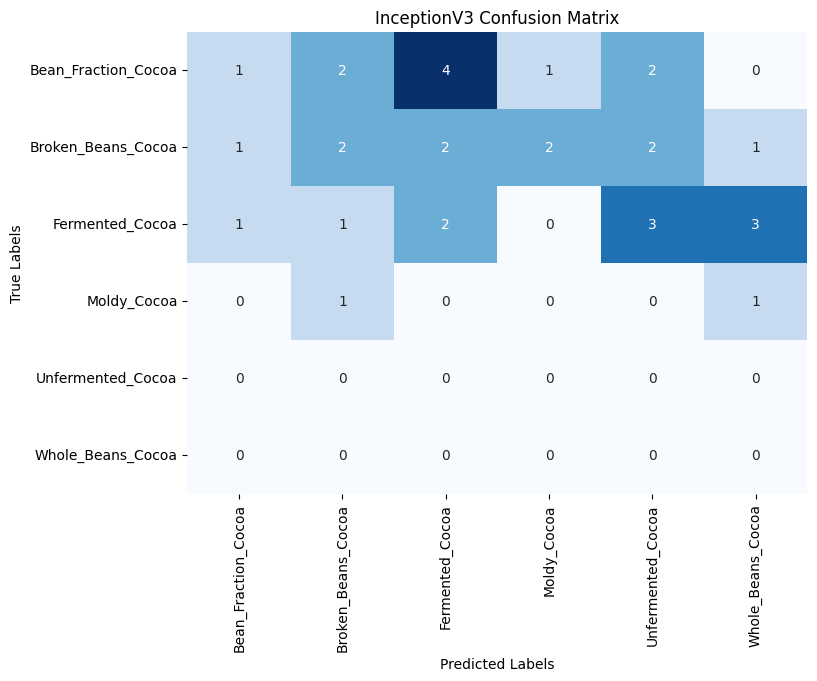

In [ ]:
#@title InceptionV3 model training and evaluation
train_and_evaluate(inceptionv3_model, "InceptionV3")

Epoch 1/50
65/65 [==============================] - ETA: 0s - loss: 1.3983 - accuracy: 0.5111 - precision_3: 0.6262 - recall_3: 0.3946 - auc_3: 0.8257

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 22s 241ms/step - loss: 1.3983 - accuracy: 0.5111 - precision_3: 0.6262 - recall_3: 0.3946 - auc_3: 0.8257 - val_loss: 1.4116 - val_accuracy: 0.4670 - val_precision_3: 0.6041 - val_recall_3: 0.4132 - val_auc_3: 0.8264
Epoch 2/50
65/65 [==============================] - 14s 222ms/step - loss: 0.8506 - accuracy: 0.7045 - precision_3: 0.7943 - recall_3: 0.5977 - auc_3: 0.9323 - val_loss: 1.9371 - val_accuracy: 0.4375 - val_precision_3: 0.4582 - val_recall_3: 0.3906 - val_auc_3: 0.7989
Epoch 3/50
65/65 [==============================] - 15s 222ms/step - loss: 0.5689 - accuracy: 0.8250 - precision_3: 0.8881 - recall_3: 0.7558 - auc_3: 0.9668 - val_loss: 1.5001 - val_accuracy: 0.6562 - val_precision_3: 0.6721 - val_recall_3: 0.6406 - val_auc_3: 0.8927
Epoch 4/50
65/65 [==============================] - 14s 222ms/step - loss: 0.4811 - accuracy: 0.8554 - precision_3: 0.8995 - recall_3: 0.8095 - auc_3: 0.9761 - val_loss: 2.3892 - val_accuracy: 0.5712 - va

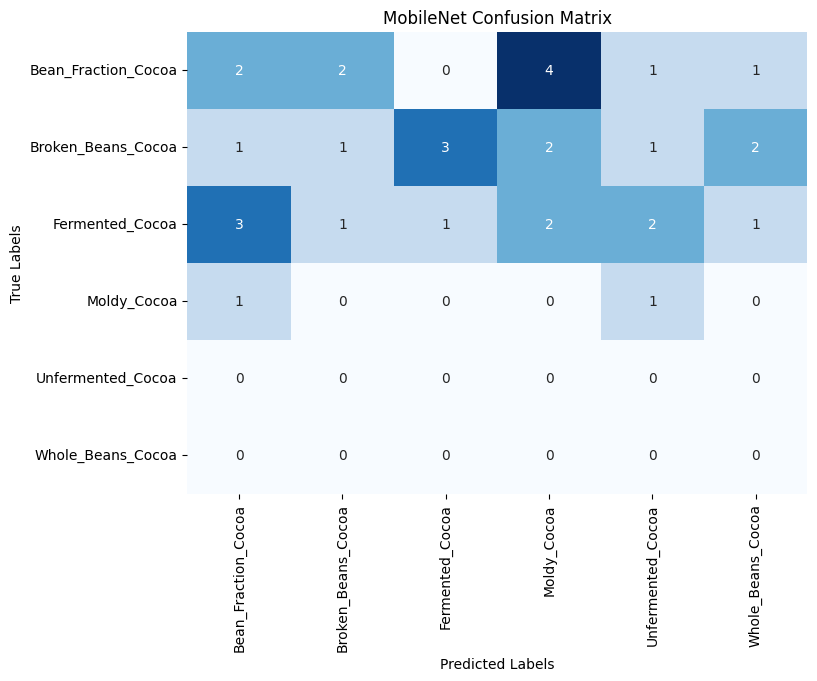

In [ ]:
#@title MobileNet model training and evaluation
train_and_evaluate(mobilenet_model, "MobileNet")

# 3. Model Interpretability

In [ ]:
#@title a. Gradient Class Activation Mapping
def generate_cam(model, img, class_index, layer_name):
    img = np.expand_dims(img, axis=0)
    grad_model = Model(inputs=model.inputs, outputs=(model.get_layer(layer_name).output, model.output))

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img)
        class_output = predictions[:, class_index]

    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0].numpy()

    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)

    # Avoid division by zero
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    else:
        heatmap = np.zeros_like(heatmap)

    return heatmap

In [ ]:
def find_sample_image(class_dir):
    image_files = []

    # Check if the directory exists
    if not os.path.exists(class_dir):
        return None

    for file in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file)
        if os.path.isfile(file_path) and file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(file_path)

    if image_files:
        return random.choice(image_files)
    else:
        return None

In [ ]:
def list_subfolders(directory):
    subfolders = [entry.path for entry in os.scandir(directory) if entry.is_dir()]
    return subfolders

test_dir_path = test_dir
subfolders = list_subfolders(test_dir_path)

print(f"Subfolders in '{test_dir_path}':")
for folder in subfolders:
    print(folder)

Subfolders in '/content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test':
/content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Moldy_Cocoa
/content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Bean_Fraction_Cocoa
/content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Unfermented_Cocoa
/content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Broken_Beans_Cocoa
/content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Whole_Beans_Cocoa
/content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Fermented_Cocoa


In [ ]:
# Extract class names from subfolder names
classes = [os.path.basename(folder) for folder in subfolders]

class_samples = {}

# Iterate through each class
for class_name in classes:
    class_dir = os.path.join(test_dir_path, class_name)
    sample_image_path = find_sample_image(class_dir)
    if sample_image_path:
        class_samples[class_name] = sample_image_path

print("Sample images from each class:")
for class_name, image_path in class_samples.items():
    print(f"{class_name}: {image_path}")

Sample images from each class:
Moldy_Cocoa: /content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Moldy_Cocoa/MD01_146.jpg
Bean_Fraction_Cocoa: /content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Bean_Fraction_Cocoa/BF 01_8.jpg
Unfermented_Cocoa: /content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Unfermented_Cocoa/UF05_07.jpg
Broken_Beans_Cocoa: /content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Broken_Beans_Cocoa/BR01_74.jpg
Whole_Beans_Cocoa: /content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Whole_Beans_Cocoa/WB01_27.jpg
Fermented_Cocoa: /content/drive/MyDrive/Datasets/Cocoa Beans Dataset/test/Fermented_Cocoa/FR01_71.jpg



Grad-CAM for Custom_CNN Model:


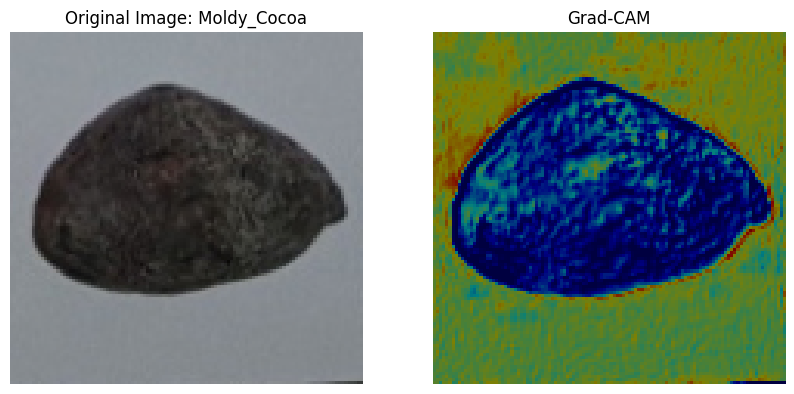

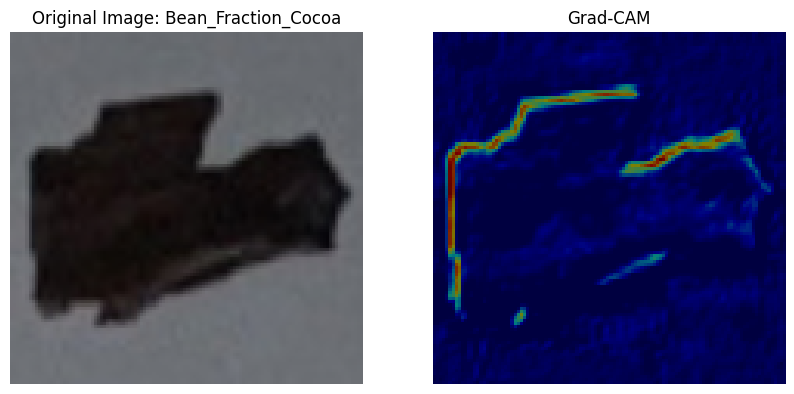

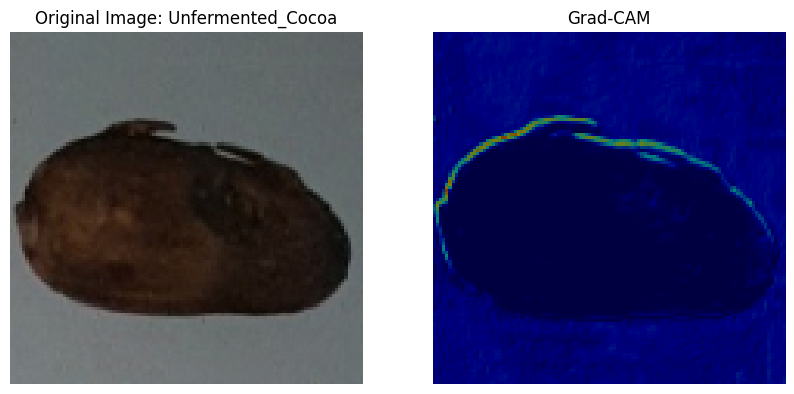

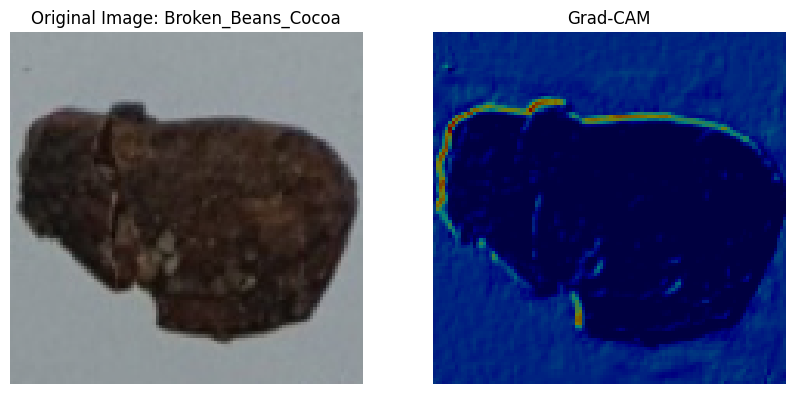

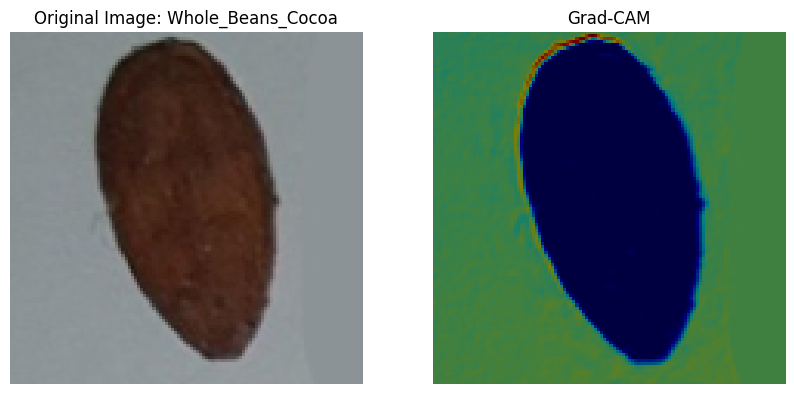

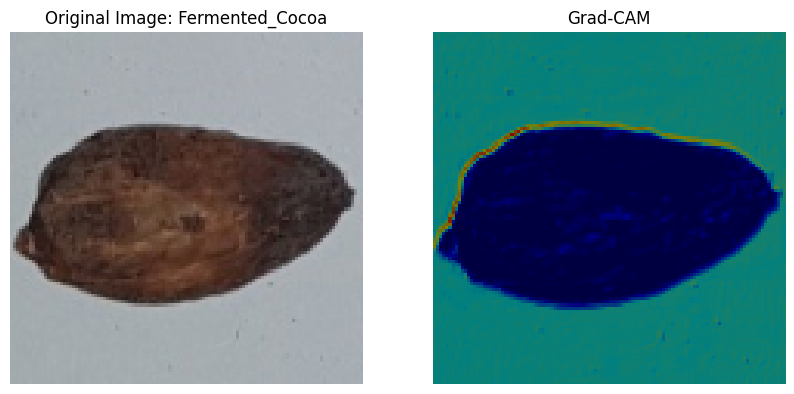


Grad-CAM for InceptionV3 Model:


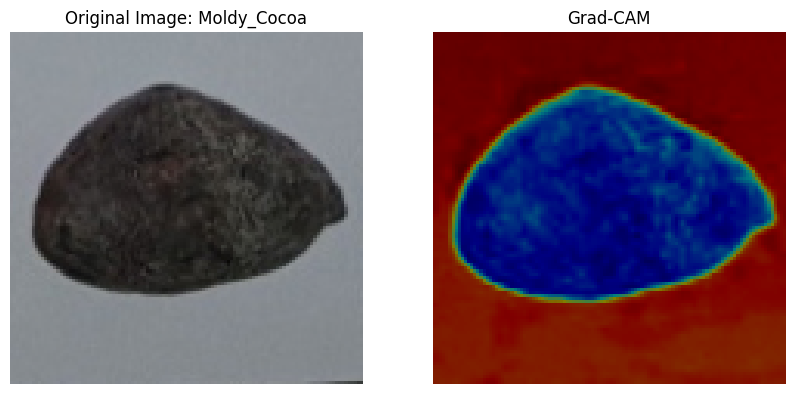

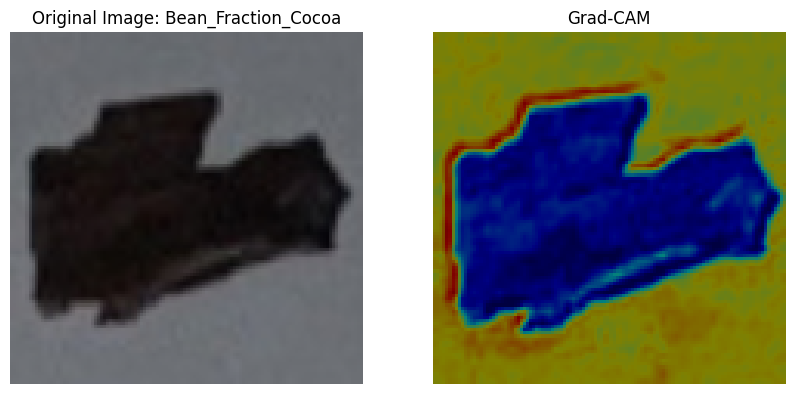

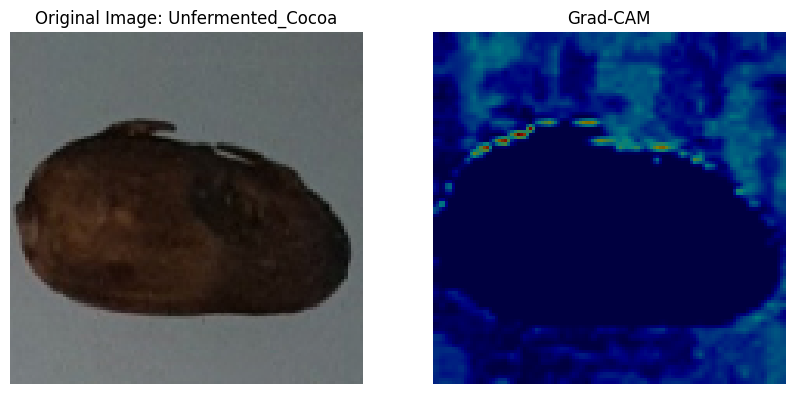

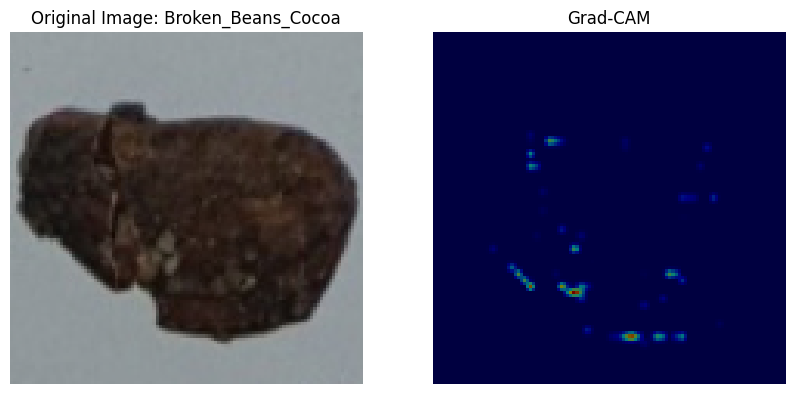

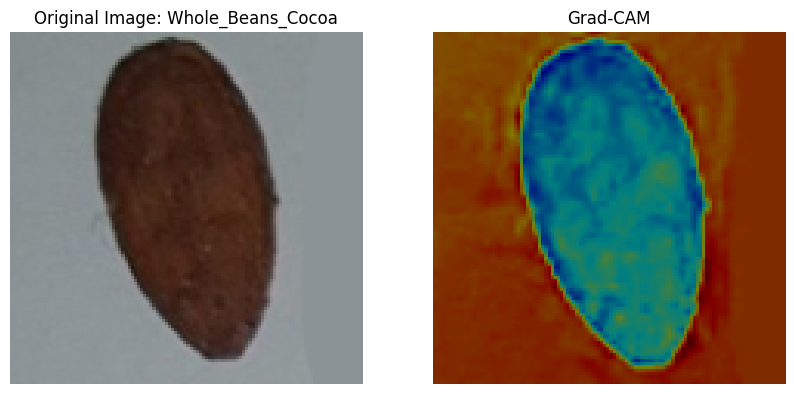

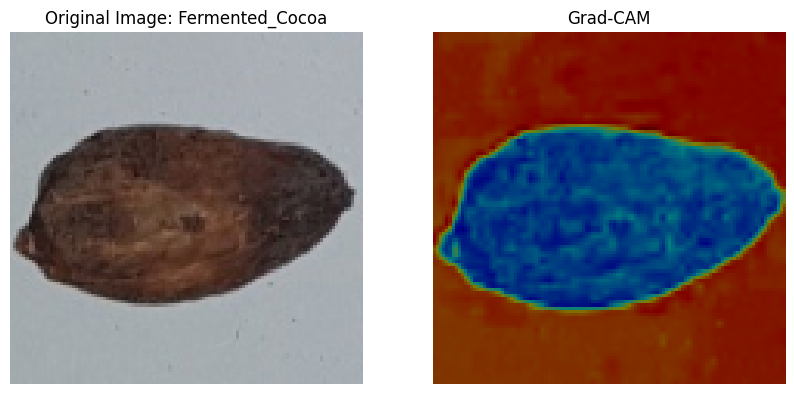


Grad-CAM for MobileNet Model:


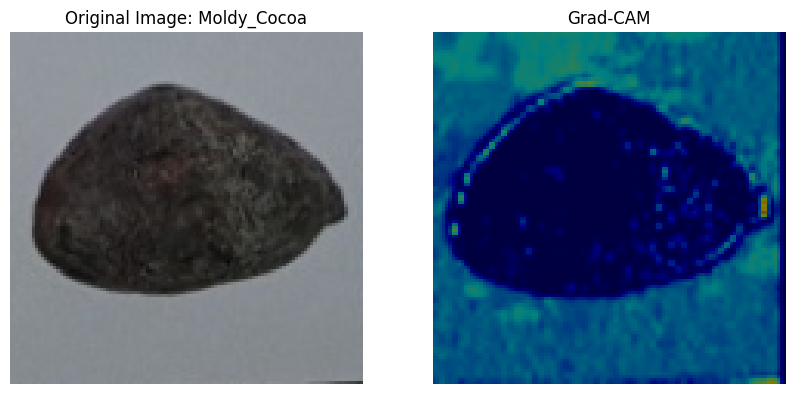

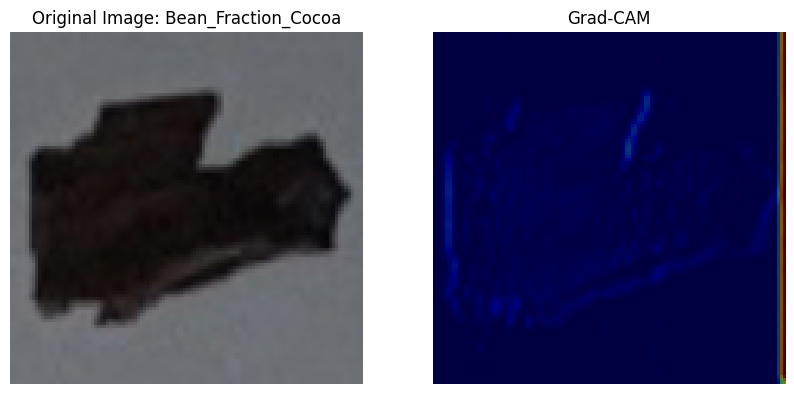

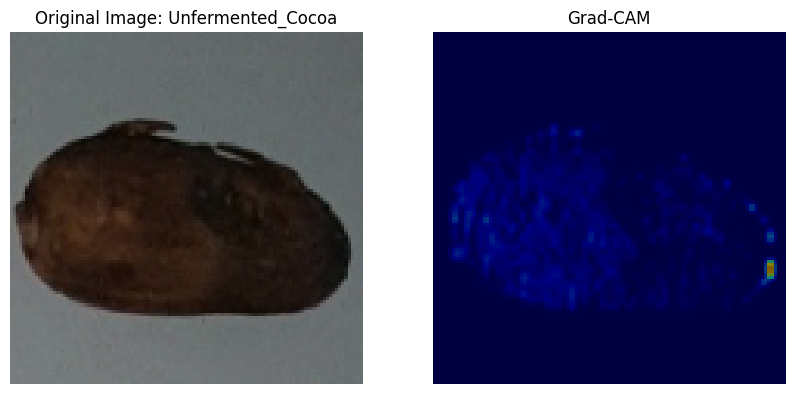

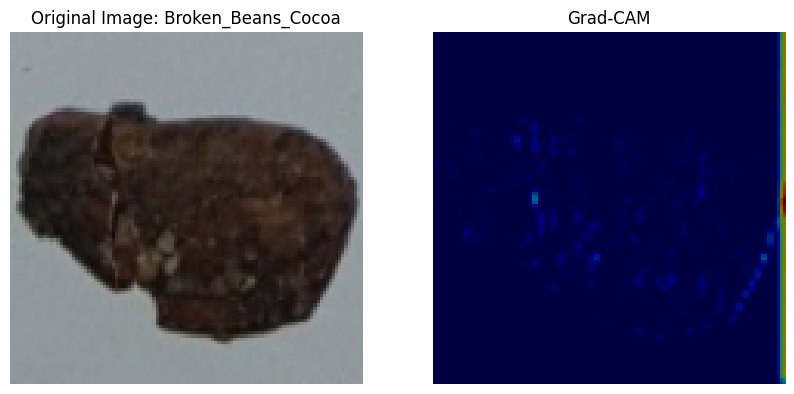

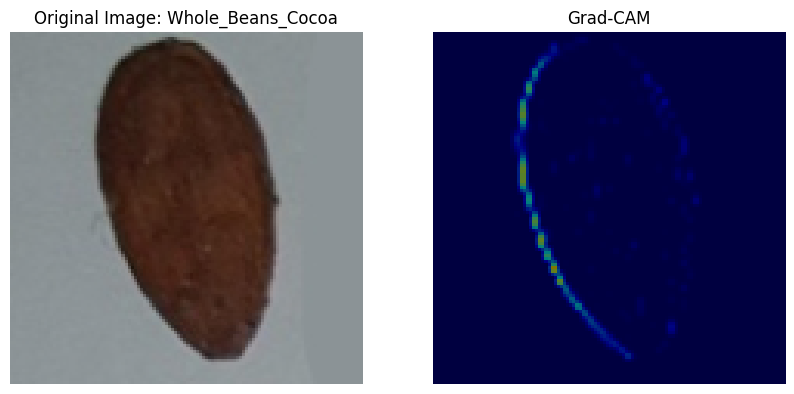

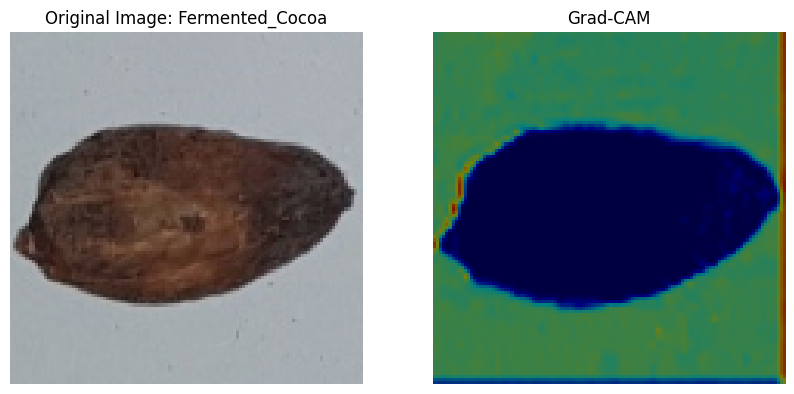

In [ ]:
#@title Generating Grad-CAMs for each model
# Generate CAM and overlay heatmap for each class sample
for model, model_name, last_conv_layer in zip(
        [cnn_model, inceptionv3_model, mobilenet_model],
        ["Custom_CNN", "InceptionV3", "MobileNet"],
        ['Conv_1', 'conv2d', 'conv1']
):
    print(f"\nGrad-CAM for {model_name} Model:")
    for class_name, image_path in class_samples.items():
        original_img = cv2.imread(image_path)
        if original_img is None:
            print(f"Error: Unable to load image at path {image_path}")
            continue

        original_img = cv2.resize(original_img, (image_size[0], image_size[1]))
        original_img = original_img.astype(np.float32) / 255.0
        class_index = classes.index(class_name)
        heatmap = generate_cam(model, original_img, class_index, last_conv_layer)
        heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(original_img.astype(np.float32), 0.5, heatmap, 0.5, 0, dtype=cv2.CV_8U)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image: {class_name}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.title('Grad-CAM')
        plt.axis('off')
        plt.show()

In [ ]:
# Save Custom CNN model
cnn_model_save_path = '/content/drive/MyDrive/Results and output/Cocoa Beans Classification/Saved models/cnn_model.h5'
cnn_model.save(cnn_model_save_path)

# Save InceptionV3 model
inceptionv3_model_save_path = '/content/drive/MyDrive/Results and output/Cocoa Beans Classification/Saved models/inceptionv3_model.h5'
inceptionv3_model.save(inceptionv3_model_save_path)

# Save MobileNet model
mobilenet_model_save_path = '/content/drive/MyDrive/Results and output/Cocoa Beans Classification/Saved models/mobilenet_model.h5'
mobilenet_model.save(mobilenet_model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save Custom CNN model
cnn_model_save_path = '/content/drive/MyDrive/Results and output/Cocoa Beans Classification/Saved models/production/SavedModel format/cnn_model'
tf.saved_model.save(cnn_model, cnn_model_save_path)

# Save InceptionV3 model
inceptionv3_model_save_path = '/content/drive/MyDrive/Results and output/Cocoa Beans Classification/Saved models/production/SavedModel format/inceptionv3_model'
tf.saved_model.save(inceptionv3_model, inceptionv3_model_save_path)

# Save MobileNet model
mobilenet_model_save_path = '/content/drive/MyDrive/Results and output/Cocoa Beans Classification/Saved models/production/SavedModel format/mobilenet_model'
tf.saved_model.save(mobilenet_model, mobilenet_model_save_path)

In [ ]:
# Convert and save Custom CNN model
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_cnn_model = converter.convert()
tflite_cnn_model_save_path = '/content/drive/MyDrive/Results and output/Cocoa Beans Classification/Saved models/production/Tflite format/cnn_model.tflite'
with open(tflite_cnn_model_save_path, 'wb') as f:
    f.write(tflite_cnn_model)

# Convert and save InceptionV3 model
converter = tf.lite.TFLiteConverter.from_keras_model(inceptionv3_model)
tflite_inceptionv3_model = converter.convert()
tflite_inceptionv3_model_save_path = '/content/drive/MyDrive/Results and output/Cocoa Beans Classification/Saved models/production/Tflite format/inceptionv3_model.tflite'
with open(tflite_inceptionv3_model_save_path, 'wb') as f:
    f.write(tflite_inceptionv3_model)

# Convert and save MobileNet model
converter = tf.lite.TFLiteConverter.from_keras_model(mobilenet_model)
tflite_mobilenet_model = converter.convert()
tflite_mobilenet_model_save_path = '/content/drive/MyDrive/Results and output/Cocoa Beans Classification/Saved models/production/Tflite format/mobilenet_model.tflite'
with open(tflite_mobilenet_model_save_path, 'wb') as f:
    f.write(tflite_mobilenet_model)